<a href="https://colab.research.google.com/github/thakerpragnesh/DeepLearning/blob/master/02_Cifar10resnetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorboard

In [ ]:
# import library to perform file operation
import os #use to access the files 
import tarfile # use to extract dataset from zip files

#import torch library to build neural network
import torch  # Elementory function of tensor is define in torch package
import torch.nn as nn # Several layer architectur is define here
import torch.nn.functional as F # loss function and activation function

# import torch library related to data processing
import torchvision # provides facilities to access image dataset
from torchvision.datasets.utils import download_url 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
project_name='05b-cifar10-resnet'

#### To access the google drive to load data or to store result such as model we will run belove cell. When we run below cell it gives a link and on clicking on that google will ask you to select gmail account to use. After selecting google account it will ask for permision and once you allowed it generate a key copy that key and past in a text box generated as output.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

#### Select a proper batchsize and then divide the training and validation data into several minibatch of selected batchsize. 

#### We will perform diffrent transform for training data and validation data as data augmentaion and shuffle is not required during validation. 1st we found mean and standard deviation of each color and used this stat for narmalization.#



In [ ]:
bs = 128 # choose an apropriate batch size
# Channelwise mead and variance
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 

# Here we perform channelwise normalization, we add reflect border of 4 pixel
# and then perform random clip of 32x32 image
train_transform = transforms.Compose([
                         transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(), 
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)])

# We only perform channelwise normalization and no data augmentation
valid_transform = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize(*stats)])

# Download CIFAR10 training dataset and store it in trainset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

# Dataloader divides the dataset into minibatches and shuffle =true indicate
# that shuffel the data during each epoch
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)

# Download CIFAR10 test dataset and store it in testset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=valid_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)

classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

#trainset.shape

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Shuffle the data before each epoch & then form minibatch of given size.
train_dl = iter(trainloader)
# As we dont need to store the gradient of each parameter during inference we 
# can use double batch size. During validation suffel is not require.
valid_dl = iter(testloader)

In [ ]:
train_dl

In [ ]:
def show_batch(dl):
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images, labels = data
        print(f"shape of input is {images.shape}")
        print(f"shape of target is {labels.shape}")
        print(labels)
    #for images, labels in dl:
        # down sample input images by 12x12 pixel and show 64 image
        fig, ax = plt.subplots(figsize=(12, 12)) 
        ax.set_xticks([]); ax.set_yticks([]) 
        ax.imshow(make_grid(images[:96], nrow=8).permute(1, 2, 0)) 
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of input is torch.Size([128, 3, 32, 32])
shape of target is torch.Size([128])
tensor([7, 7, 4, 5, 6, 1, 0, 2, 4, 8, 0, 1, 6, 0, 7, 5, 1, 6, 7, 4, 1, 9, 2, 4,
        0, 4, 7, 8, 5, 7, 7, 6, 5, 5, 5, 6, 5, 1, 6, 6, 5, 5, 2, 4, 2, 6, 2, 1,
        2, 9, 0, 6, 6, 1, 8, 4, 4, 3, 2, 5, 9, 5, 2, 7, 3, 0, 7, 5, 3, 4, 5, 3,
        9, 0, 1, 6, 7, 9, 4, 5, 8, 1, 4, 6, 7, 6, 9, 6, 7, 5, 1, 4, 2, 2, 3, 8,
        7, 0, 1, 1, 5, 4, 9, 1, 3, 1, 2, 9, 7, 5, 5, 0, 7, 1, 8, 7, 4, 3, 6, 4,
        4, 1, 1, 9, 5, 5, 4, 6])


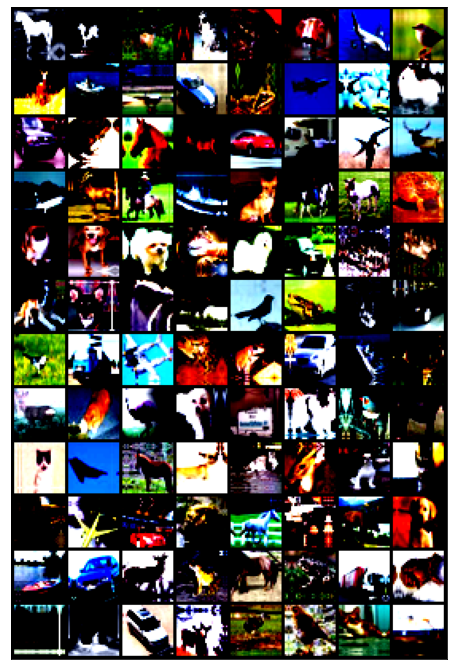

In [ ]:
show_batch(train_dl)

In [ ]:
# if Cuda enable graphic card is present choose CUDA device
def get_default_device():
    #Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Copy data to selected device memory
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device() # Returns cuda or cpu based on system
device

/home/pragnesh/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

#### Every Image classification task need to perform several basic taks that can be usefull to see the perfromance of the model. Such as maintaining training loss history, maintaining validation loss and validation accuracy history, accuracy, and checking the progress after each epoch. And thus we can design a common template for this.#

In [ ]:
# compute accuracy = total correct prediction / total number f ele
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) # get the prediction vector
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    
    # Compute loss of the given batch and return it
    def compute_batch_loss(self, batch):
        images, labels = batch 
        images, labels = batch[0].to(device), batch[1].to(device)
        
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    # Computes loss and accuracy of the given batch(Used in validation)
    def compute_batch_loss_acc(self, batch):
        images, labels = batch
        images, labels = batch[0].to(device), batch[1].to(device)

        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    # At the end of epoch accumulate all batch loss and batch accueacy    
    def accumulate_batch_loss_acc(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        #print(batch_losses)
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
      # Print in given format 
      # Epoch [0], last_lr: 0.00278, train_loss: 1.2862, val_loss: 1.2110, val_acc: 0.6135
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

#### In following architecture all convolution layer will have same convolution with 3x3 filter followed by batch-normalization and thus we create template for it.

#### Then we define the architecture of our neural network with 9 learning layer and 2 resnet block and thus we will call it Resnet9

In [ ]:
# As for all the conv layer we are going to use will have 3x3 filter and padding =1
# so it produce same convolution operation we create tamplate for it

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), # Layerwise Noramlizarion
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2)) 
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # C1(03,64)    -> 64x32x32
        self.conv1 = conv_block(in_channels, 64)

        # C2(64,128)   -> 128x16x16
        self.conv2 = conv_block(64, 128, pool=True)                              
        
        # CR1(128,128) -> 128x16x16 
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))     
        
        # C3(128.256)  -> 256x8x8
        self.conv3 = conv_block(128, 256, pool=True)                              
        
        # C4(256,512)  -> 512x4x4
        self.conv4 = conv_block(256, 512, pool=True)                              
        
        # CR2(512,512) -> 512x4x4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))     
        
        # (Pool(4x4) -> 512x1x1) -> (Convert it into vector) -> FC(512x10)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),                          
                                        nn.Flatten(),
                                        #nn.Dropout(p= 0.4),                            
                                        nn.Linear(512, num_classes))               
        
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out # skip connection 
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out # skip connection
        
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, 10), device)
#model

#### Here we are using 1-CylceLR learning algorith in which 1st we need to find the optimal learning rate using learning rate finder. 

#### That value will be use as max-lr. In 1-Cycle algorithm we start with 1/10th of max-lr and then gradully increase the learning rate 35% of run then for 10 we run traing with max-lr and then gradaully decreses the learning rate to its initial value for next 35% of run. 

#### Finally for last 10% run we fruther reduce learning rate to fine tune the model.

#### We used a few state of art technique to improve learning. 1at we interduces weight-decay that perfoems L2 regularization on neural network and help to stop a tiny set of feature to be dominant.

#### Then we use gradient clipping as sometime gradient of some parameter become very high but at that time we want to make sure that no parameter make jump then a maximum limit.

#### We tried dropout in this model and it did not busted the performance so we comented that part during network architecture defination.

In [ ]:
@torch.no_grad()
# evalute model on validation dataset
def evaluate(model, data_loader):
    model.eval()
    outputs = [model.compute_batch_loss_acc(batch) for batch in data_loader]
    return model.accumulate_batch_loss_acc(outputs)

# Use special scheduler to change the value of learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

###########################################################################

# epoch=8, max_lr=.01, weight_decay(L2-Regu parametr)=.0001,opt_func=Adam
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()  #######################
        train_losses = []
        lrs = []
        #for batch in train_loader:
        for i, batch in enumerate(trainloader, 0):
            
            # computer the training loss of current batch
            loss = model.compute_batch_loss(batch) 
            train_losses.append(loss)
            loss.backward() # compute the gradient of all weights
            
            # Clip the gradient value to maximum allowed grad_clip value
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step() # Updates weights 
            # pytorch by default accumulate grade history and if we dont want it
            # we should make all previous grade value equals to zero
            optimizer.zero_grad() 
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step() # Update the learning rate
        
        # Compute Validation Loss and Valodation Accuracy
        result = evaluate(model, testloader) 

        # Compute Train Loss of whole epoch i.e mean of loss of batch 
        result['train_loss'] = torch.stack(train_losses).mean().item()

        # Observe how learning rate is change by schedular
        result['lrs'] = lrs

        # print the observation of each epoch in a proper format
        model.epoch_end(epoch, result) 
        history.append(result) # append tupple result with val_acc, vall_loss, and trin_loss
    return history

#### If we have saved trained resnet9 model in our drive and we want to use it then we can load train model from google drive

In [ ]:
# path = '/content/gdrive/My Drive/ColabNotebooks/TrainedModel/cifar_resnet10/model50'
# model = torch.load(path)

In [ ]:
history = []

#### Run the training model for selected number of epoch. Select apropriate hyper parameter such as max_lr, grad_clip, weight_decay. Select optimizer function we want to use. Store required reslut in history to check the performance of training.

In [ ]:
epochs = 2
# We are using onc cycle fit function in which learning rate start with 1/10th 
# of selected maximum learning rate and increase learning rate from min to max
# in 1st phase and then decrease from max to min in 2nd phase
max_lr = 0.001  
grad_clip = 0.01
# weight decay is a constant multiplier of L2 regularization
weight_decay = 1e-4
# Choosing Adma optimizer as try to implement SGD+Momentum+Adaptive Learining
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

In [ ]:
# Plot Validation accuracy Over Epoch
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
# Plot training and validation loss to check for overfitting and underfitting
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
# plot the learning rate values over each batch
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_accuracies(history)

In [ ]:
plot_losses(history)

In [ ]:
plot_lrs(history)

#### If we want to save the model we can choose appropriate filename and save it to google drive at intended loacation define by path

In [ ]:
#path = "/content/gdrive/My Drive/ColabNotebooks/TrainedModel/cifar_resnet10/"
#torch.save(model,(path+"93_5"))

In [ ]:
accuracies = [x['val_acc']*100 for x in history]
accuracies = ["%.2f" % v for v in accuracies]
print(accuracies)

In [ ]:
def accuraciesTotal(data_loader):
  acc = []
  for batch in data_loader:
    images, label = batch
    images, labels = batch[0].to(device), batch[1].to(device)
    out = model(images)
    acc.append(accuracy(out, labels))
    
  return torch.mean(torch.stack(acc))
  

In [ ]:
trainacc = accuraciesTotal(trainloader)
testacc = accuraciesTotal(testloader)
print("Train Acc :" + str(trainacc) + "\nTest  Acc :" +str(testacc))